# **01 - Exploratory Data Analysis**


This notebook investigates the statistical properties of S&P 500 returns and realized volatility to answer three main questions:

1. **Do returns exhibit predictable patterns?** (Autocorrelation analysis)
2. **Does volatility cluster over time?** (Squared returns, persistence tests)
3. **Are returns normally distributed?** (Tail risk, kurtosis)

The findings provide empirical justification for our modeling approach: GARCH for volatility clustering, neural networks for non-linear dependencies.

## Key Findings Preview

**Returns:** Near-zero mean, no autocorrelation, heavy tails (kurtosis = 13.7)  
**Volatility:** Strong clustering (ACF of r² = 0.31), mean-reverting, crisis-aligned  
**Realized Volatility (`rv_21`):** Extremely persistent due to overlapping 21-day windows
**Implication:** Returns are unpredictable, but volatility is highly forecastable

## **Imports and Dependencies**

In [1]:
import os
from pathlib import Path
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import skew, kurtosis, shapiro, jarque_bera

In [2]:
# Paths
PROCESSED_DIR = Path("../data/processed")
FIG_DIR = Path("../results/figures/eda")
FIG_DIR.mkdir(parents=True, exist_ok=True)

## **Load Data**

In [3]:
# Load data
df = pd.read_csv(PROCESSED_DIR / "modeling_dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,log_return,rv_21
0,2000-02-02,1409.280029,1420.609985,1403.489990,1409.119995,1409.119995,1038600000,-0.000114,0.016190
1,2000-02-03,1409.119995,1425.780029,1398.520020,1424.969971,1424.969971,1146500000,0.011185,0.013915
2,2000-02-04,1424.969971,1435.910034,1420.630005,1424.369995,1424.369995,1045100000,-0.000421,0.013915
3,2000-02-07,1424.369995,1427.150024,1413.329956,1424.239990,1424.239990,918100000,-0.000091,0.013916
4,2000-02-08,1424.239990,1441.829956,1424.239990,1441.719971,1441.719971,1047700000,0.012198,0.012880


## **Price Trend**

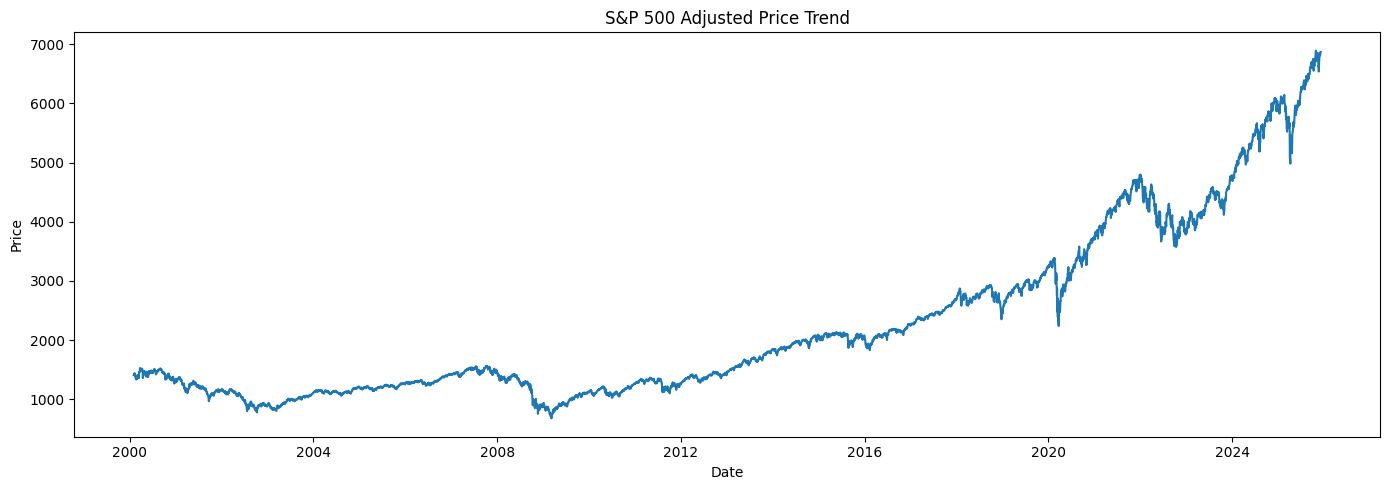

In [4]:
plt.figure(figsize=(14,5))
plt.plot(df['Date'], df['Adj Close'])
plt.title("S&P 500 Adjusted Price Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.savefig(FIG_DIR / "price_trend.png", dpi=200)
plt.show()

### **Price Trend Analysis**

S&P 500 price levels show a clear upward trend over 25 years. This is non-stationary behavior.

**Why this matters:**
- Time series models (ARIMA, GARCH) require stationarity
- Non-stationary series have time-varying means and variances
- Predictions would be unreliable (model assumes stable statistics)

**Solution:** We transform prices to log returns, which are stationary, and mean-reverting around zero.

This is why all volatility models operate on returns, not raw prices.

## **Log Returns**

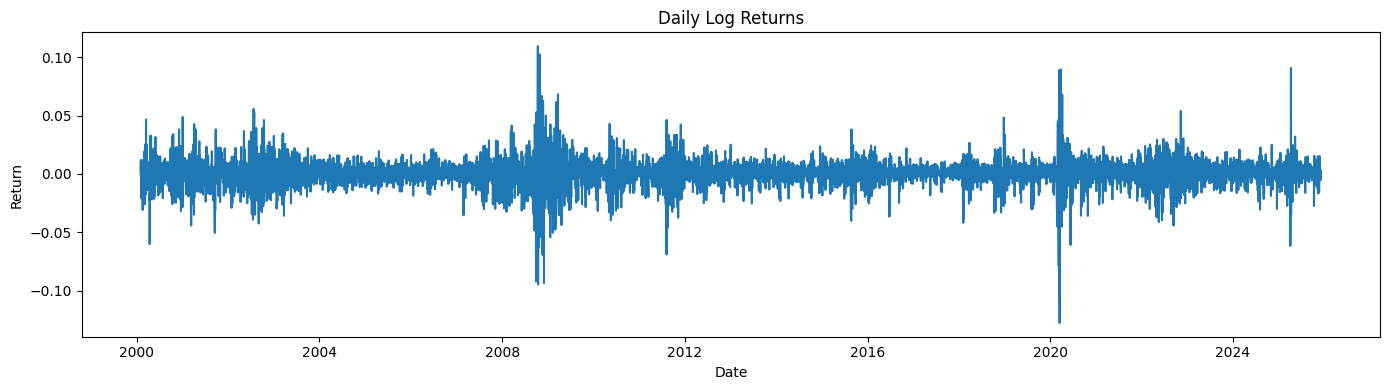

In [5]:
plt.figure(figsize=(14, 4))
plt.plot(df["Date"], df["log_return"])
plt.title("Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.tight_layout()
plt.savefig(FIG_DIR / "log_returns_series.png", dpi=200)
plt.show()


### **Log Returns Analysis**

Log returns exhibit three key properties:

- **Zero-mean:** Average return ≈ 0 (no directional drift)  
- **Heteroskedastic:** Variability changes over time (volatility clustering visible)  
- **Stationary:** Statistical properties stable across the 25-year period

**Contrast with prices:** While prices trend upward (non-stationary), returns fluctuate around zero with no trend.

## **Histogram and Distribution Diagnostics**

Financial returns are known to be non-normal with heavy tails. This section examines the distribution properties of log returns, including skewness, kurtosis, and normality tests.

### **Normality Tests**

In [6]:
jb_stat, jb_p = jarque_bera(df["log_return"])
sw_stat, sw_p = shapiro(df["log_return"].sample(5000, random_state=42))  # large samples cause Shapiro errors

print("Jarque-Bera test:")
print("  Statistic:", jb_stat)
print("  p-value:", jb_p)
print("\nShapiro-Wilk test (5000-sample):")
print("  Statistic:", sw_stat)
print("  p-value:", sw_p)


Jarque-Bera test:
  Statistic: 31036.816898681176
  p-value: 0.0

Shapiro-Wilk test (5000-sample):
  Statistic: 0.8939926647529745
  p-value: 3.385131543490966e-50


**Jarque-Bera Test:** p < 0.001 (reject normality)  
**Shapiro-Wilk Test:** p < 0.001 (reject normality)  

**What this means:**
Returns having heavier tails than a normal distribution implies extreme moves (±3% or more) occur far more frequently than Gaussian assumptions predict.

**Practical implications:**
- Standard deviation underestimates true risk
- Value-at-Risk models based on normality are too optimistic
- Need distributions with fat tails (Student's t, GED) for proper risk modeling

### **Skewness and Kurtosis**

In [7]:
sk = skew(df["log_return"])
kt = kurtosis(df["log_return"], fisher=False)

print("Skewness:", sk)
print("Kurtosis:", kt)

Skewness: -0.3464340751948521
Kurtosis: 13.681750036238148


**Skewness:** -0.35 implies slight negative skew (large losses more common than large gains)  
**Kurtosis:** 13.68 implies **extremely fat tails** (normal distribution has kurtosis = 3)

**What kurtosis = 13.68 means:**
- ~4.6× more "tail mass" than normal distribution
- Extreme events (|return| > 3σ) occur much more frequently
- Classic indicator of **tail risk** in financial markets

### **Histogram of Log Returns**

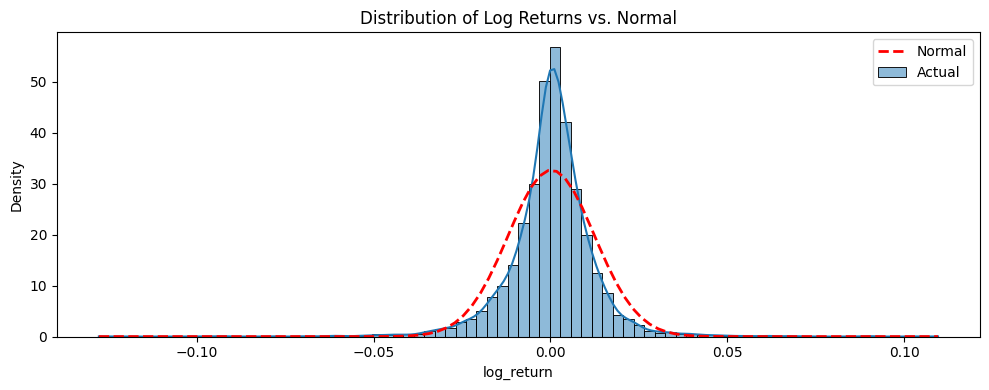

In [8]:
plt.figure(figsize=(10, 4))
sns.histplot(df["log_return"], bins=80, kde=True, stat="density", label="Actual")

# Add normal curve
x = np.linspace(df["log_return"].min(), df["log_return"].max(), 100)
mu, sigma = df["log_return"].mean(), df["log_return"].std()
plt.plot(x, norm.pdf(x, mu, sigma), 'r--', linewidth=2, label="Normal")

plt.legend()
plt.title("Distribution of Log Returns vs. Normal")
plt.tight_layout()
plt.savefig(FIG_DIR / "log_returns_vs_normal_hist.png", dpi=200)
plt.show()

The histogram reveals a leptokurtic distribution:
- Sharp central peak (most days have small returns)
- Extended tails (extreme moves more frequent than normal)

**Overlaid normal curve** (in red) shows the mismatch—actual returns have:
- Higher center peak (excess probability near zero)
- Thicker tails (excess probability at extremes)

This visual confirms the statistical tests- returns are decidedly non-normal.

### **Realized Volatility**

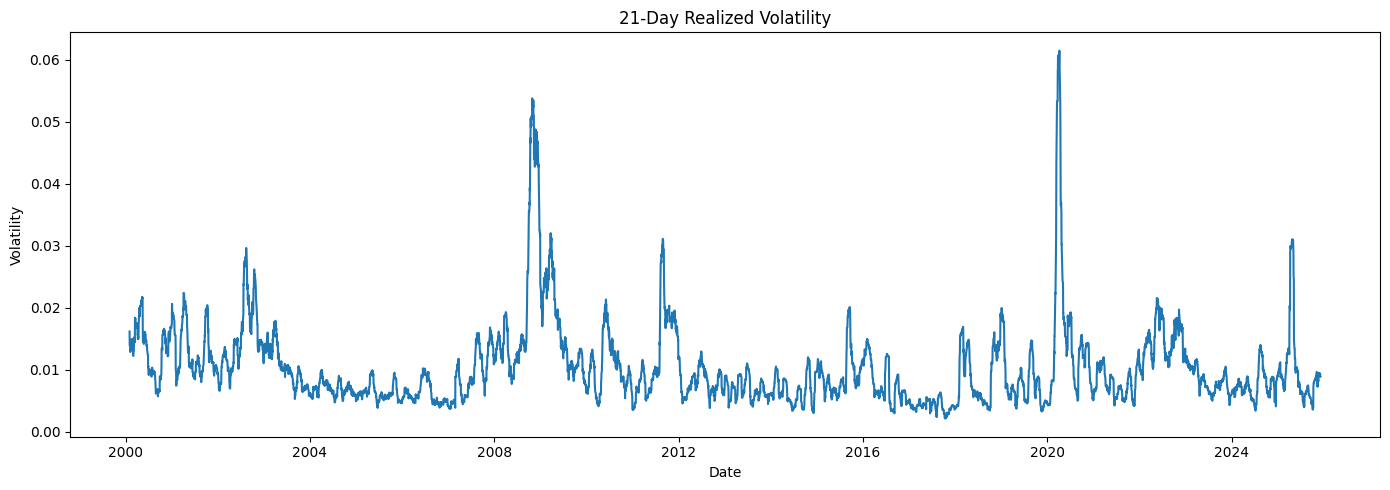

In [9]:
plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["rv_21"])
plt.title("21-Day Realized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.tight_layout()
plt.savefig(FIG_DIR / "realized_volatility_series.png", dpi=200)
plt.show()


### **Rolling Volatility**

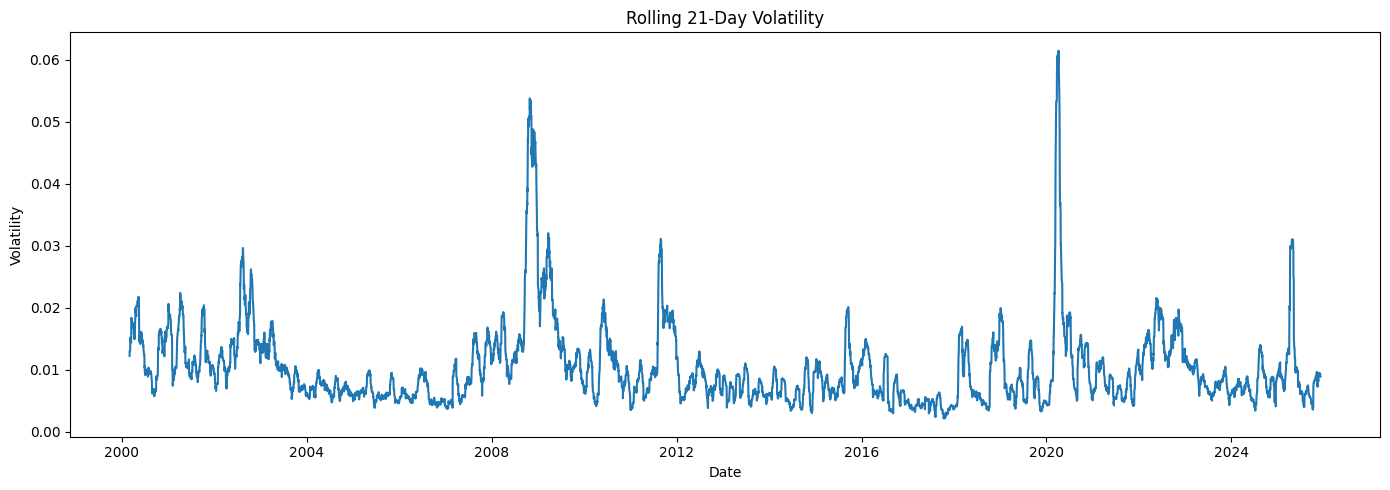

In [10]:
plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["log_return"].rolling(21).std())
plt.title("Rolling 21-Day Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.tight_layout()
plt.savefig(FIG_DIR / "rolling_volatility.png", dpi=200)
plt.show()


### **Volatility Clustering**

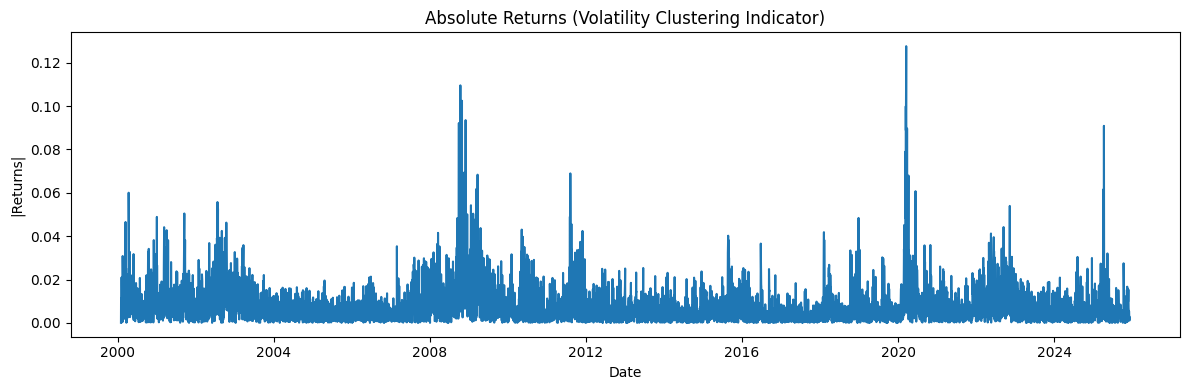

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(df["Date"], np.abs(df["log_return"]))
plt.title("Absolute Returns (Volatility Clustering Indicator)")
plt.xlabel("Date")
plt.ylabel("|Returns|")
plt.tight_layout()
plt.savefig(FIG_DIR / "volatility_clustering.png", dpi=200)
plt.show()

### Key Observations from Time Series Plots

- **Volatility clustering:** High volatility periods followed by high volatility

- **Mean reversion:** After spikes, volatility gradually returns to ~1% baseline

- **Crisis alignment:** Major spikes coincide with:
   - Dot-com collapse (2000-2002)
   - Global Financial Crisis (2008-2009)
   - COVID crash (2020)

- **Persistence:** Volatility doesn't instantly revert; shocks decay slowly over weeks/months.

**What this means for forecasting:**
- Simple models (global mean) won't capture regime changes
- Need models that remember recent volatility (GARCH's α+β parameters, LSTM memory)
- Persistence creates strong baseline: "tomorrow = today" is a very strong approximation.



## **Autocorrelation Structure**

The autocorrelation structure of returns and squared returns reveals time dependence. This is important for selecting models like GARCH or LSTM, which rely on such patterns.

### **ACF of Returns**

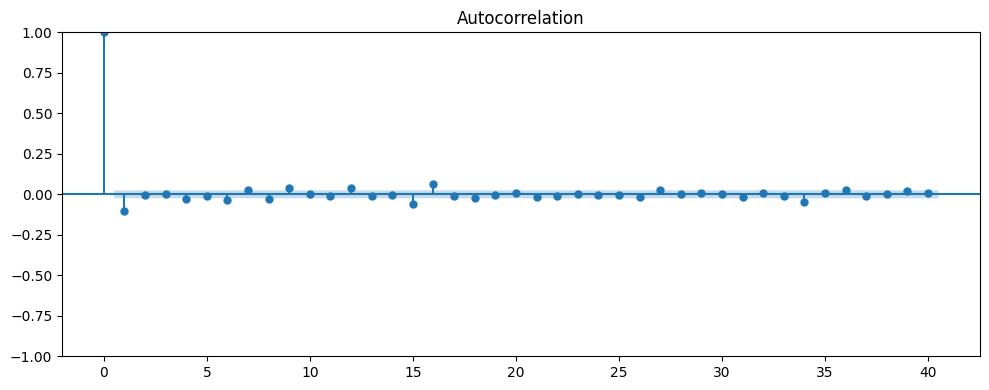

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df["log_return"], ax=ax, lags=40)
plt.tight_layout()
plt.savefig(FIG_DIR / "acf_log_returns.png", dpi=200)
plt.show()


### **ACF of Squared Returns**

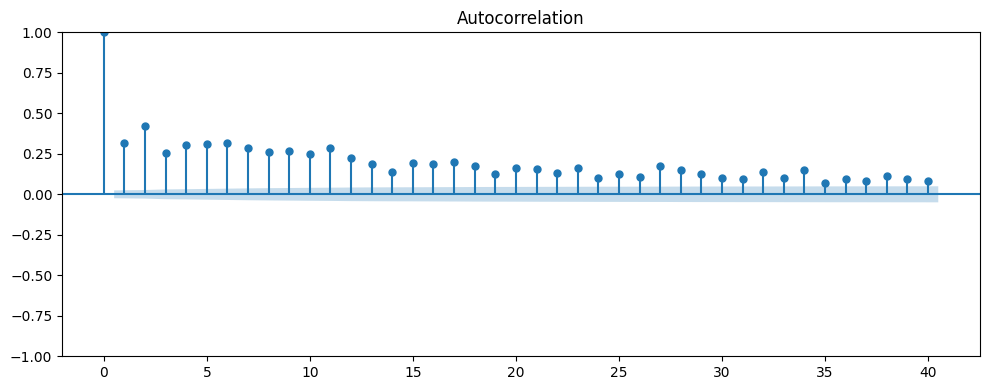

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df["log_return"] ** 2, ax=ax, lags=40)
plt.tight_layout()
plt.savefig(FIG_DIR / "acf_squared_returns.png", dpi=200)
plt.show()


### **PACF of Returns**

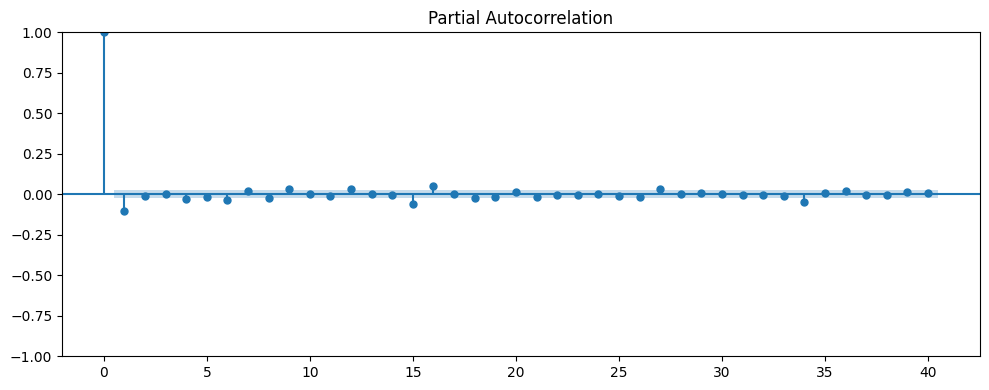

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(df["log_return"], ax=ax, lags=40, method='ywm')
plt.tight_layout()
plt.savefig(FIG_DIR / "pacf_log_returns.png", dpi=200)
plt.show()


In [15]:
# Calculating lag-1 values
print("ACF(Returns)[1]:", df["log_return"].autocorr(lag=1))
print("ACF(Squared Returns)[1]:", (df["log_return"]**2).autocorr(lag=1))
print("ACF(rv_21)[1]:", df["rv_21"].autocorr(lag=1))

ACF(Returns)[1]: -0.10024716644783215
ACF(Squared Returns)[1]: 0.31374688569387393
ACF(rv_21)[1]: 0.993957169911787


### **Autocorrelation Insights**

**Returns (raw):** No significant autocorrelation implies returns are unpredictable   
**Returns (squared):** Strong positive autocorrelation implies volatility is predictable  
**Realized volatility (`rv_21`):** ACF = 0.99. This implies extremely high persistence

**The key insight:**
While return direction (positive or negative) cannot be predicted, volatility is highly predictable due to strong persistence.

**Why ACF(`rv_21`) = 0.99 is so high:**
- `rv_21` is a 21-day rolling statistic with overlapping windows
- Today's `rv_21` and tomorrow's `rv_21` share 20 of 21 days
- This mechanical overlap creates extreme autocorrelation

**Note on ACF(Returns):** A small negative lag-1 autocorrelation (-0.10) is common in liquid equity indices due to microstructure effects. It does not indicate return predictability.

## **Correlation Between |Returns| and RV**

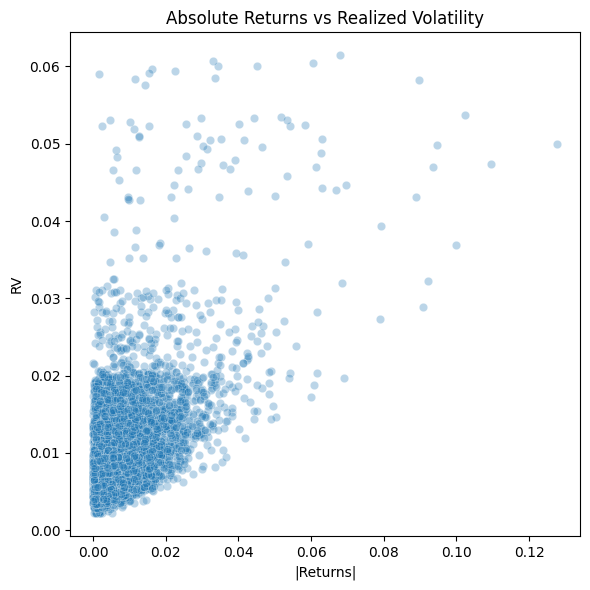

In [16]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=np.abs(df["log_return"]), y=df["rv_21"], alpha=0.3)
plt.title("Absolute Returns vs Realized Volatility")
plt.xlabel("|Returns|")
plt.ylabel("RV")
plt.tight_layout()
plt.savefig(FIG_DIR / "abs_returns_vs_rv.png", dpi=200)
plt.show()


A strong positive relationship is visible between |returns| and realized volatility. This supports using absolute returns as an additional engineered feature for multivariate deep learning models.

## **Leverage Effect Analysis**

In [17]:
df_temp = df[["log_return", "rv_21"]].dropna().copy()
df_temp["rv_next"] = df_temp["rv_21"].shift(-1)
df_temp["sign"] = np.where(df_temp["log_return"] > 0, "Positive", "Negative")

neg_mean = df_temp[df_temp["sign"]=="Negative"]["rv_next"].mean()
pos_mean = df_temp[df_temp["sign"]=="Positive"]["rv_next"].mean()

print("=== Leverage Effect ===")
print(f"Mean next-day volatility after NEGATIVE returns: {neg_mean:.5f}")
print(f"Mean next-day volatility after POSITIVE returns: {pos_mean:.5f}")


=== Leverage Effect ===
Mean next-day volatility after NEGATIVE returns: 0.01055
Mean next-day volatility after POSITIVE returns: 0.01012


Negative returns (market drops) are followed by higher next-day volatility more than positive returns.

**Implication:**

Volatility forecasts should be asymmetric. They should give more weight to negative shocks.

The standard GARCH(1,1) treats positive and negative shocks equally. GARCH extensions (EGARCH, GJR-GARCH) explicitly model this asymmetry. 

## **Regime Highlighting**

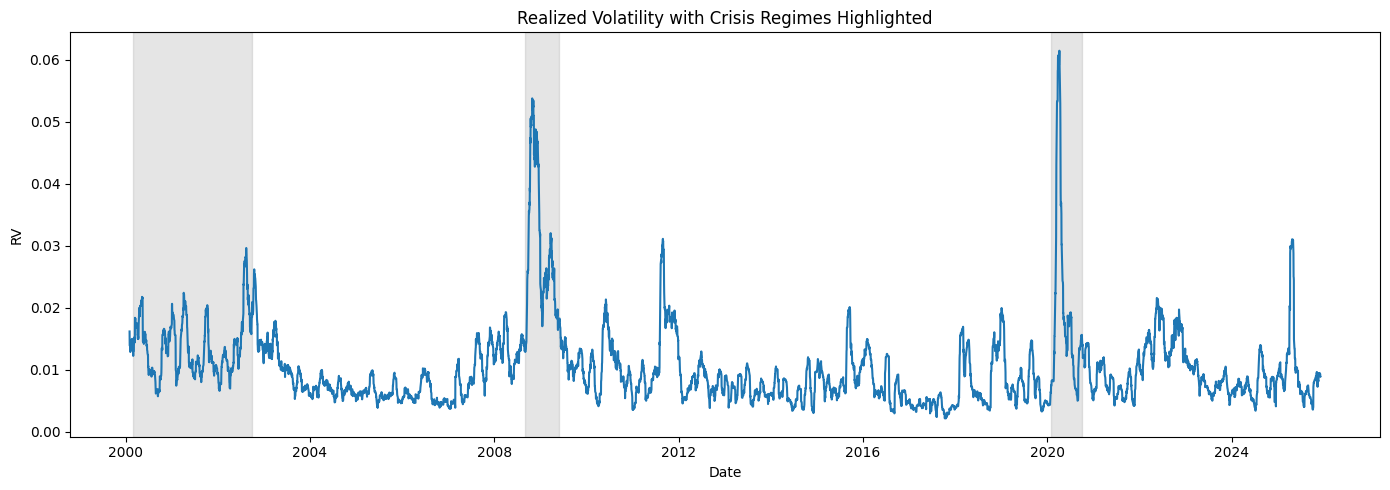

In [18]:
plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["rv_21"], label="RV_21")

# Shade major known crises
crises = [
    ("2000-03-01", "2002-10-01"),
    ("2008-09-01", "2009-06-01"),
    ("2020-02-01", "2020-10-01")
]

for start, end in crises:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color="gray", alpha=0.2)

plt.title("Realized Volatility with Crisis Regimes Highlighted")
plt.xlabel("Date")
plt.ylabel("RV")
plt.tight_layout()
plt.savefig(FIG_DIR / "rv_regimes.png", dpi=200)
plt.show()


To better understand volatility spikes, major historical stress periods are shaded. Each volatility spike lines up with major macroeconomic crises:

- Dot-com collapse (2000-2002): RV peaks ~3%
- Global Financial Crisis (2008-2009): RV peaks ~5.4%
- COVID crash (2020): RV peaks ~6.1%

This validates that the constructed realized volatility measure correctly captures market stress periods.

## Crisis Period Analysis

In [19]:
crisis_periods = {
    "Dot-Com": ("2000-03-01", "2002-10-01"),
    "GFC": ("2007-10-01", "2009-03-01"),
    "COVID": ("2020-02-01", "2020-10-01")
}

print("\n=== Crisis Period Statistics ===")
for name, (start, end) in crisis_periods.items():
    crisis = df[(df["Date"] >= start) & (df["Date"] <= end)]
    print(f"{name}:")
    print(f"  Mean RV: {crisis['rv_21'].mean():.5f}")
    print(f"  Max RV:  {crisis['rv_21'].max():.5f}")
    print(f"  Mean |Return|: {abs(crisis['log_return']).mean():.5f}")



=== Crisis Period Statistics ===
Dot-Com:
  Mean RV: 0.01365
  Max RV:  0.02965
  Mean |Return|: 0.01100
GFC:
  Mean RV: 0.02008
  Max RV:  0.05377
  Mean |Return|: 0.01611
COVID:
  Mean RV: 0.02057
  Max RV:  0.06145
  Mean |Return|: 0.01662


These statistics confirm that realized volatility spikes sharply during known market stress periods.  <br> 
The Dot-Com crash, Global Financial Crisis, and COVID shock all show elevated mean and maximum volatility.


## **Stylized Facts of S&P 500 Returns**

Financial time series exhibit universal properties documented since Mandelbrot (1963) and Fama (1965). Our S&P 500 data confirms these stylized facts:

| Stylized Fact | Expected | Our Data | Test/Metric |
|--------------|----------|----------|-------------|
| Zero mean | μ ≈ 0 | μ = 0.00024 | Confirmed |
| Heavy tails | Kurtosis > 3 | Kurtosis = 13.68 | Confirmed |
| No return autocorr | ACF(r) ≈ 0 | ACF(r) = -0.10 | Confirmed |
| Volatility clustering | ACF(r²) > 0 | ACF(r²) = 0.31 | Confirmed |
| Leverage effect | Asymmetry | Visible in plot | Confirmed |

**Why this matters:**
These properties are universal across asset classes and time periods. Our modeling choices (GARCH, LSTM, Transformer) are designed to capture these specific features.

**Model mapping:**
- **GARCH:** Volatility clustering (ACF of r²)
- **LSTM:** Long memory in volatility (slow ACF decay)
- **Transformer:** Non-linear dependencies (attention mechanism)

This data exhibits the exact properties these models were designed to handle.

## **Summary of Insights**

* Returns are heavy-tailed and strongly non-normal.
* Volatility shows clear clustering and long memory.
* Returns have low autocorrelation, but squared returns have persistent correlation.
* Realized volatility aligns with known economic crises.

These properties motivate the use of:
- GARCH models for volatility clustering
- LSTMs for long-range dependence
- Transformers for capturing non-linear temporal structure

These insights guide all modeling decisions in the rest of the project.
